In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy import signal
import matplotlib.pyplot as pl
%matplotlib inline

### Machine parameters for PMSM 
We try to create parameter set for 3 types of PMSM
1. IPMSM $l_d < l_q$
2. IPMSM $l_d > l_q$
3. EPMSM $l_d = l_q$

In [2]:
#Defining Machine parameters 

mach_ramu = {"rs": 0.1729, "lq": 0.6986, "ld": 0.4347, "tmech":50.5}
mach_servo = {"rs": 0.0426, "ld": 2.252+0.078, "lq": 2.252+0.078, "tmech":100.0}
mach_servodq = {"rs": 0.0426, "ld": 2.252+0.078, "lq": 2.252+0.0758, "tmech":100.0}

### Getting machine parameters 

In [3]:
def mach_parapm(dict):
    """Takes in the dictionary containing machine parameters (normalized)
       and returns various parameters that are used in space vector equations
       
       Takes arguement: machine dictionary
       """
    rs = dict["rs"]
    lq = dict['lq']
    ld = dict['ld']
    tsq=lq/rs
    tsd=ld/rs
    tmech = dict['tmech']
    psirm = 0.9
#     print("lh = {0:1.3f}".format(lh))
    return rs,lq,ld,tmech,psirm

def mach_parapmSym(dict):
    """Takes in the dictionary containing machine parameters (normalized)
       and returns various parameters that are used in space vector equations
       
       Takes arguement: machine dictionary
       """
    rs = dict["rs"]
    lq = dict['lq']
    ld = dict['ld']
    ls = dict['ld']
    tsq=lq/rs
    tsd=ld/rs
    tmech = dict['tmech']
    psirm = 0.95
#     print("lh = {0:1.3f}".format(lh))
    return rs,ls,tmech,psirm

#Test 
mach_parapmSym(mach_servo)

(0.0426, 2.3299999999999996, 100.0, 0.95)

#### Define PMSM model in stator coordinates with Ld = Lq

This models is for machine is stator coordinates. For simplicity we will assume $l_d = l_q$, which is the case with most surface-mounted permanent magnets on rotor. 
\begin{align}
\vec{v}_s &= r_s\vec{i}_s + \frac{d\vec{\psi}_s}{d\tau} \\
\vec{\psi}_s& = l_s\vec{i}_s + \vec{\psi_{r,m}}
\end{align}
Where $\psi_{r,m}$ is the rotor flux coupling with the stator winding. Hence, we get 

\begin{align}
\vec{v}_s & = r_s\vec{i}_s + l_s\frac{d\vec{i}_s}{d\tau} + \frac{d\vec{\psi}_{r,m}}{d\tau}\\
\vec{\psi}_{r,m} &= |\psi_{r,m}|e^{j\delta} = \psi_{r,m\alpha} + j\psi_{r,m\beta}\\ 
\vec{v}_s & = r_s\vec{i}_s + l_s\frac{d\vec{i}_s}{d\tau} + j\omega_s\vec{\psi}_{r,m} \\
v_{s\alpha} &= r_si_{s\alpha} + l_s\frac{di_{s\alpha}}{d\tau} - \omega_s\psi_{r,m\beta} \\
v_{s\beta} &= r_si_{s\beta} + l_s\frac{di_{s\beta}}{d\tau} + \omega_s\psi_{r,m\alpha}
\end{align}


In [4]:
# Dynamic model in stator coordinates for symmetrical PMSM rotor


#PMSM machine 4x4 dynamic model 

def PMSM_dynstepstatorSym(X,t,params):
    """Defines a function to calculate the derivatives for a 4x4 PMS motor dynamice
       1. Uses state variables stator current $\vec{i}_s$ and rotor flux space vector $\vec{\psi}_r$.
       2. Is non-linear and uses the state variable $\omega$ rotor angular velocity to describe
          rotor dynamics
       3. calls mach_im function to calculate the system equation coefficients
       4. mach_im will in  turn call mach_para function.
       5. uses normalized time 2*np.pi*50*t
       6. This is to be used in a for loop for the time span
    """
    x0 = X[0]  #isalpha
    x1 = X[1]  #isbeta
    x2 = X[2]  #ws
    x3 = X[3]  #delta
    
#     wx = X[5]
    u1,u2,mL,rs,ls,tmech,psirm = params
    

#     rs,ls,tmech,psirm = mach_parapmSym(mach_servo)
#     rs,ls,tmech,psirm = mach_parapmSym(mach_ramu)
    psrma = psirm*np.cos(x3)
    psrmb = psirm*np.sin(x3)
    mdiff = (psrma*x1 - psrmb*x0) - mL
#     print(A[1][0],A[1][1],A[1][2],A[1][3],B[4][0])
    dx0dt = -(rs/ls)*x0  + psrmb*x2 + u1/ls
    dx1dt = -(rs/ls)*x1 - psrma*x2 + u2/ls
    dx2dt = mdiff/tmech
    dx3dt = x2
#     dwxdt = rate
    return [dx0dt,dx1dt,dx2dt,dx3dt]




In [5]:
def rotorangle(X,t,params):
    del0 = X
    w = params
    ddel0dt = w
    return ddel0dt

In [6]:
def PIcon(xe,y,dt,Kparams):
    """Pass on xe = [error[k], error[k-1]]
       Pass on y  = [y[k-1]]
       Pass on Parameters = [kp, Ti]
    """
    kp, Ti = Kparams
    xeo = xe[1]
    xen = xe[0]
#     print(xeo,xen,y,kp,Ti)
    y1 = y
    y2 = y1 + kp*(xen - xeo) + (kp/Ti)*(xen)
    return y2

def PIconwithLim(xe,y,dt,Kparams):
    """Pass on xe = [error[k], error[k-1]]
       Pass on y  = [y[k-1]]
       Pass on Parameters = [kp, Ti]
    """
    kp, Ti, uplim, dwnlim = Kparams
    xeo = xe[1]
    xen = xe[0]
#     print(xeo,xen,y,kp,Ti)
#     y2 = y1 + kp*(xen - xeo) + (kp/Ti)*(xen)
#     print(xeo,xen,y,kp,Ti)
    y1 = y
    yx = y1 + kp*(xen - xeo) + (kp/Ti)*(xen)
    if (yx > uplim):
        yx = uplim
    elif (yx < dwnlim):
        yx = dwnlim
    y2 = yx
    return y2

In [19]:
#Preparing simulation with current control
# We will use for loop


# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-3

tend = 20*2*np.pi
tstart = 0.0
delta_t = 0.01
n = 100000
n2 = int(100*2*np.pi/0.01)
ws = -0.5
mL = 0.0
Tta = np.arange(tstart, tend,delta_t)
# Tta = np.linspace(tstart, tend, n2)
#delta_t = Tta[1] - Tta[0]
usa = np.zeros(len(Tta))
usb = np.zeros(len(Tta))
sol1 = np.zeros((len(Tta),4))
sol2 = np.zeros(len(Tta))
FCangle = np.zeros(len(Tta))
gamma = np.zeros(len(Tta))
# Field coordinate currents
cosdelta = np.zeros(len(Tta))
sindelta = np.zeros(len(Tta))
isa = np.zeros(len(Tta))
isb = np.zeros(len(Tta))
w = np.zeros(len(Tta))
gamma = np.zeros(len(Tta))
isd = np.zeros(len(Tta))
isq = np.zeros(len(Tta))
usd = np.zeros(len(Tta))
usq = np.zeros(len(Tta))
eid = np.zeros(len(Tta))
eiq = np.zeros(len(Tta))

#Creating reference values for isd and isq
isdrefval = 0.01
isdref = np.zeros(len(Tta))
isqref = np.zeros(len(Tta))

isqref1 = 0.0
isqref2 = 0.9
isqref3 = -0.35
for ii in range(len(Tta)):
    isdref[ii] = isdrefval
    if (Tta[ii]>=18*2*np.pi):
        isqref[ii] = isqref3
    elif(Tta[ii]>=1*2*np.pi):
        isqref[ii]=isqref2
    else:
        isqref[ii]=isqref1
        

# 
rs,ls,tmech, psirm = mach_parapmSym(mach_servo)
rs,ls,tmech,psirm = mach_parapmSym(mach_servo)
psird = np.zeros(len(Tta))
psirq = np.zeros(len(Tta))

me = np.zeros(len(Tta))
x0 = [0.0,0.0,ws,0]

kp = 5.5
Ti = 5.0e1

Kparams = [kp,Ti]

#isdref = 0.26
#isqref = 0.75
#The intial value error will never get corrected in 
#rotor angle
y0 = 0
for ii in range(len(Tta)):
    #Start controller after first step
    if ii>=0:
        eid[ii] = isdref[ii-1] - isd[ii-1]
        PIed = [eid[ii],eid[ii-1]]
        print("PIed=")
        print(PIed)
        usd[ii] = PIcon(PIed, usd[ii-1], delta_t,Kparams) 
        eiq[ii] = isqref[ii-1] - isq[ii-1]
        PIeq = [eiq[ii],eiq[ii-1]]
        usq[ii] = PIcon(PIeq, usq[ii-1], delta_t,Kparams)
        print("usd, usq")
        print(usd, usq)
#         usd[ii] = 0
#         usq[ii] =.0001
    if ws>=1.0:
        a = 1.0
    else: 
        a = ws
#     usa[ii] = a*np.cos(ws*Tta[ii])
#     usb[ii] = a*np.sin(ws*Tta[ii])
    usa[ii] = usd[ii-1]*cosdelta[ii-1] - usq[ii-1]*sindelta[ii-1]
    usb[ii] = usq[ii-1]*cosdelta[ii-1] + usd[ii-1]*sindelta[ii-1]
#     me[ii] = kr*(sol1[ii-1][2]*sol1[ii-1][1] - sol1[ii-1][3]*sol[ii-1][0]) - mL
    params = [usa[ii], usb[ii],mL,rs,ls,tmech,psirm]
    sol1a = odeint(PMSM_dynstepstatorSym,x0,[0,delta_t], args = (params,),atol = abserr, rtol= relerr)
    sol1[ii]= sol1a[-1]
#     display(sol1a[-1])
    x0 = sol1a[-1]
    params2 = sol1[ii][2] #  w
    sol2a = odeint(rotorangle,y0,[0,delta_t], args = (params2,), atol = abserr, rtol= relerr)
    sol2[ii] = sol2a[-1]
    #Using the internal state of the machine
    #for internal model use sol1[ii][3]
    #Change this to resolver model
    #Resolver model use sol2[ii]
    FCangle[ii] = sol2[ii] #sol1[ii][3]
    cosdelta[ii] = np.cos(FCangle[ii])
    sindelta[ii] = np.sin(FCangle[ii])
    #Coordinate transformation 
    isa[ii] = sol1[ii][0]
    isb[ii] = sol1[ii][1]
    w[ii] = sol1[ii][2]
    gamma[ii] = sol1[ii][3]
    #Convert stator coordinate current to field coordinates
    isd[ii] = sol1[ii][0]*cosdelta[ii] + sol1[ii][1]*sindelta[ii]
    isq[ii] = sol1[ii][1]*cosdelta[ii] - sol1[ii][0]*sindelta[ii]
    #Rotor flux in field coordinates Using estimator output as in practice
    #actual flux will not be available for measurement
    psird[ii] = 1.0
    y0 = sol2a[-1]
    psird[ii] = psirm

#Do not use these assigments    
# isa = sol1[:, 0]
# isb = sol1[:, 1]
# w = sol1[:, 2]
# gamma = sol1[:,3]




me = psirm*isq



PIed=
[0.01, 0.0]
usd, usq
[0.0561 0.     0.     ... 0.     0.     0.    ] [-1.9635  0.      0.     ...  0.      0.      0.    ]
PIed=
[0.010011873657496206, 0.01]
usd, usq
[0.0561     0.05726661 0.         ... 0.         0.         0.        ] [-1.9635     -0.06514493  0.         ...  0.          0.
  0.        ]
PIed=
[0.009764611429659184, 0.010011873657496206]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[0.009534745331786275, 0.009764611429659184]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[0.00932892857585304, 0.009534745331786275]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[0.009146320222169902, 0.00932892857585304]
usd, usq
[0.0561     0.057

  0.        ]
PIed=
[0.0020327823023579064, 0.001986680115136339]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[0.0020772396058495388, 0.0020327823023579064]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[0.002120062926141317, 0.0020772396058495388]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[0.002161263690624249, 0.002120062926141317]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[0.0022008538385389883, 0.002161263690624249]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 

PIed=
[0.11690169350501099, 0.1172913834520307]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[0.11646720403989307, 0.11690169350501099]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[0.11598853143429531, 0.11646720403989307]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[0.11546631469663853, 0.11598853143429531]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[0.1149012145285198, 0.11546631469663853]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.       

  0.        ]
PIed=
[-0.007236528210262503, -0.007579737978787632]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.006897676146154977, -0.007236528210262503]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.00656324213020631, -0.006897676146154977]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.006233283353184996, -0.00656324213020631]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.005907853888868048, -0.006233283353184996]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.045042

PIed=
[-0.0014965973349089865, -0.0014973364531942288]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.001495922797907787, -0.0014965973349089865]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0014953116885550542, -0.001495922797907787]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.001494762853380802, -0.0014953116885550542]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0014942751395497587, -0.001494762853380802]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...

[-0.0016188042248823174, -0.0016187878347964733]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016188204727675213, -0.0016188042248823174]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016188365764117727, -0.0016188204727675213]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016188525338946078, -0.0016188365764117727]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.001618868343377997, -0.0016188525338946078]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0

[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016199752302074964, -0.0016199965709773143]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016199542395037656, -0.0016199752302074964]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016199336069198187, -0.0016199542395037656]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016199133396495678, -0.0016199336069198187]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.00161989344405398, 

[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016198736891247043, -0.0016198937851633153]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016198539244119212, -0.0016198736891247043]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016198344958984843, -0.0016198539244119212]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016198154078739067, -0.0016198344958984843]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016197966640934622

[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016194831491045478, -0.0016194817033603568]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.001619484581446182, -0.0016194831491045478]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016194860001626041, -0.001619484581446182]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.001619487405036488, -0.0016194860001626041]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016194887958576685, -

PIed=
[-0.0016191834363047473, -0.0016191810615036693]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016191858218301911, -0.0016191834363047473]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016191882170680325, -0.0016191858218301911]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016191906210382776, -0.0016191882170680325]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016191930327962376, -0.0016191906210382776]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242

PIed=
[-0.0016195280820278744, -0.0016195278214309414]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016195283321892105, -0.0016195280820278744]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016195285720317452, -0.0016195283321892105]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016195288016650575, -0.0016195285720317452]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016195290211986155, -0.0016195288016650575]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242

PIed=
[-0.0016202167511135072, -0.0016201982356237547]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.001620235276689275, -0.0016202167511135072]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.001620253810229089, -0.001620235276689275]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016202723503948944, -0.001620253810229089]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016202908966923783, -0.0016202723503948944]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...

  0.        ]
PIed=
[-0.0016190091597638265, -0.0016190081695333178]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.001619010277943653, -0.0016190091597638265]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016190115204494735, -0.001619010277943653]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016190128837157512, -0.0016190115204494735]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.001619014364185831, -0.0016190128837157512]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 

  0.        ]
PIed=
[-0.0016195125732238556, -0.0016195124847222606]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016195126568158223, -0.0016195125732238556]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016195127355943615, -0.0016195126568158223]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016195128096567844, -0.0016195127355943615]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.001619512879118332, -0.0016195128096567844]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.0651449

PIed=
[-0.001620232534961458, -0.0016202263836732431]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016202385869136197, -0.001620232534961458]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.001620244540568425, -0.0016202385869136197]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016202503970433272, -0.001620244540568425]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016202561575558525, -0.0016202503970433272]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...

PIed=
[-0.0016190866755183084, -0.001619093681629222]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016190799384805474, -0.0016190866755183084]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016190734680403638, -0.0016190799384805474]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016190672615903432, -0.0016190734680403638]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016190613164717236, -0.0016190672615903432]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 

  0.        ]
PIed=
[-0.0016194979841935384, -0.0016194975895111405]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016194983635884428, -0.0016194979841935384]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016194987280427429, -0.0016194983635884428]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016194990779253658, -0.0016194987280427429]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016194994135371819, -0.0016194990779253658]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.065144

  0.        ]
PIed=
[-0.0016198356237654508, -0.0016198341574783035]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016198370390813153, -0.0016198356237654508]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016198384037333733, -0.0016198370390813153]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016198397180323763, -0.0016198384037333733]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.001619840982310725, -0.0016198397180323763]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.0651449

[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016197871893034264, -0.0016197863283349215]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016197880685714042, -0.0016197871893034264]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016197889666638935, -0.0016197880685714042]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.001619789884167883, -0.0016197889666638935]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016197908216687238,

PIed=
[-0.001619382868804817, -0.0016193805656918945]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016193851732172002, -0.001619382868804817]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016193874780452509, -0.0016193851732172002]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016193897824160561, -0.0016193874780452509]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016193920854907038, -0.0016193897824160561]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 .

PIed=
[-0.0016196270662740628, -0.0016196260466013277]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016196280910997316, -0.0016196270662740628]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016196291203533584, -0.0016196280910997316]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016196301533398325, -0.0016196291203533584]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016196311893727586, -0.0016196301533398325]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242

PIed=
[-0.0016195956387148967, -0.001619595773187885]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016195955250116831, -0.0016195956387148967]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016195954322107495, -0.0016195955250116831]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016195953604116829, -0.0016195954322107495]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016195953097145142, -0.0016195953604116829]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 

[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016197071233146707, -0.0016197073238075708]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016197069264711293, -0.0016197071233146707]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.001619706733384971, -0.0016197069264711293]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.001619706544157726, -0.001619706733384971]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016197063588857617, -

PIed=
[-0.0016195929768549975, -0.001619593051818644]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016195929083579561, -0.0016195929768549975]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016195928462044516, -0.0016195929083579561]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016195927902150162, -0.0016195928462044516]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.001619592740258755, -0.0016195927902150162]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 .

usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.001619494259876975, -0.001619495406625664]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016194930930718884, -0.001619494259876975]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.00161949190563619, -0.0016194930930718884]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.001619490696930079, -0.00161949190563619]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.001619489466331678

PIed=
[-0.0016197806546415314, -0.0016197839948677937]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016197773121083923, -0.0016197806546415314]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016197739689670174, -0.0016197773121083923]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.001619770626890513, -0.0016197739689670174]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.001619767287509741, -0.001619770626890513]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ..

  0.        ]
PIed=
[-0.001619633286207631, -0.0016196333947721218]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016196331759768066, -0.001619633286207631]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016196330641116228, -0.0016196331759768066]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016196329506476068, -0.0016196330641116228]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016196328356312215, -0.0016196329506476068]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493

[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.001619480148793007, -0.001619482425338015]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016194778238714739, -0.001619480148793007]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.00161947544897704, -0.0016194778238714739]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016194730224501578, -0.00161947544897704]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016194705425432044, -0.00

  0.        ]
PIed=
[-0.0016197029662177818, -0.0016197096355466487]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.001619696429113646, -0.0016197029662177818]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016196900246775534, -0.001619696429113646]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016196837532751005, -0.0016196900246775534]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016196776151966106, -0.0016196837532751005]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493

PIed=
[-0.0016197123444850556, -0.0016197128242455092]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.001619711860092141, -0.0016197123444850556]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.001619711371229857, -0.001619711860092141]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.001619710878071232, -0.001619711371229857]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016197103807404998, -0.001619710878071232]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  

PIed=
[-0.0016204064417353978, -0.0016204154610208275]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016203972565073752, -0.0016204064417353978]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016203879130687413, -0.0016203972565073752]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016203784190854196, -0.0016203879130687413]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016203687821667676, -0.0016203784190854196]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242

PIed=
[-0.0016197868850120842, -0.0016197862900901947]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016197874480347128, -0.0016197868850120842]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016197879793622503, -0.0016197874480347128]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016197884791991444, -0.0016197879793622503]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016197889477755998, -0.0016197884791991444]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242

[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016204534415697833, -0.001620448615826062]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016204578473503015, -0.0016204534415697833]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016204618367875265, -0.0016204578473503015]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016204654137093408, -0.0016204618367875265]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.001620468582165033, 

  0.        ]
PIed=
[-0.0016198303525898714, -0.0016198309249423701]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016198297415218697, -0.0016198303525898714]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.001619829091705419, -0.0016198297415218697]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016198284031131247, -0.001619829091705419]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016198276756760974, -0.0016198284031131247]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493

  0.        ]
PIed=
[-0.001619651262215591, -0.001619653996443324]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016196486601517488, -0.001619651262215591]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.001619646189419852, -0.0016196486601517488]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.001619643849133776, -0.001619646189419852]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016196416383505528, -0.001619643849133776]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.0

[-0.0016196615491398478, -0.0016196601087734106]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016196630624825768, -0.0016196615491398478]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016196646467853768, -0.0016196630624825768]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016196663000259768, -0.0016196646467853768]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0016196680201787748, -0.0016196663000259768]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  

[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0005707841666254942, -0.0008869882457085872]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0002605862151914152, -0.0005707841666254942]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[4.358746800544114e-05, -0.0002605862151914152]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[0.00034172181245899734, 4.358746800544114e-05]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[0.0006338047619482753, 0

  0.        ]
PIed=
[-0.0006584748855597237, -0.0006710583792871958]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0006459942265878236, -0.0006584748855597237]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0006336194178094365, -0.0006459942265878236]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0006213533628978366, -0.0006336194178094365]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0006091988549736197, -0.0006213533628978366]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.065144

  0.        ]
PIed=
[-0.00025818586800716893, -0.0002576054344603871]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.00025874902575740745, -0.00025818586800716893]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.0002592950616836596, -0.00025874902575740745]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.00025982413334822187, -0.0002592950616836596]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0.06514493 -0.04504242 ...  0.          0.
  0.        ]
PIed=
[-0.00026033640175874596, -0.00025982413334822187]
usd, usq
[0.0561     0.05726661 0.05698078 ... 0.         0.         0.        ] [-1.9635     -0

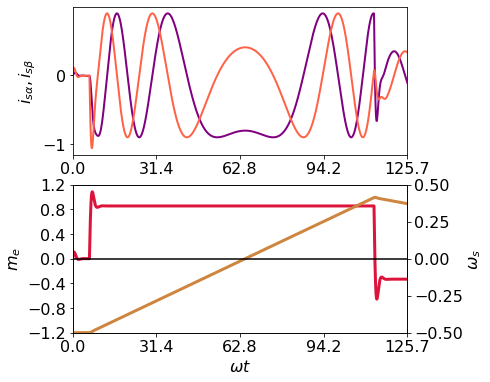

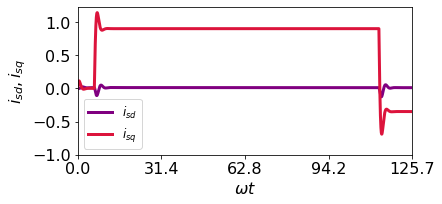

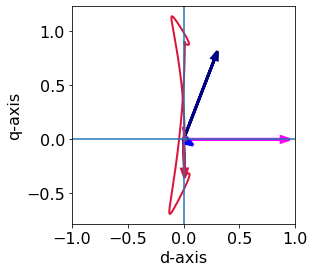

0.95


In [8]:
dirfig =  "C:/Users/ashwi/Documents/tex/lec/drives/figures/"
pl.figure(501, figsize = (6,6))
pl.rc('font', size = 16)
pl.subplot(2,1,1)
pl.plot(Tta,  isa, 'purple', Tta, isb,'tomato', lw=2) 
# pl.plot(Tta, isd,'tomato', Tta,isq ,'crimson' ,lw =2)
pl.xlim(0,tend)
pl.ylabel(r'$i_{s\alpha}, i_{s\beta}$' )
pl.xticks(np.linspace(0,tend,5))
ax1= pl.subplot(2,1,2)
ax1.plot(Tta, me, 'crimson', lw =3)
# pl.plot(Tta,w, 'peru', lw =2)
# pl.plot(Tta,gamma, 'navy')
ax1.set_ylabel(r'$m_e$' )
ax1.set_xlabel(r'$\omega t$')
ax2 = ax1.twinx()
ax2.plot(Tta,w, 'peru', lw =3)
ax2.set_yticks(np.linspace(-0.5,0.5,5))
ax2.set_ylim(-0.5,0.5)
ax1.set_yticks(np.linspace(-1.2,1.2,7))
ax1.set_ylim(-1.2,1.2)
ax2.set_ylabel(r'$\omega_s$')
ax2.axhline(0, c= 'k')
ax1.set_xlim(0,tend)
ax1.set_xticks(np.linspace(0,tend,5))
# pl.savefig(dirfig + "PMSMSpeedConurrentsvst.pdf", bbox_inches = 'tight', transparent = True)

pl.figure(521, figsize = (6,6))
pl.rc('font', size = 16)
pl.subplot(2,1,1)
pl.plot(Tta,  isd, 'purple', lw =3, label = '$i_{sd}$') 
pl.plot(Tta,isq ,'crimson' ,lw =3, label = '$i_{sq}$')
pl.xlim(0,tend)
pl.ylabel(r'$i_{sd}, i_{sq}$' )
pl.xticks(np.linspace(0,tend,5))
pl.yticks(np.linspace(-1.0,1.0,5))
pl.rcParams['legend.fontsize']=12
pl.legend(loc='lower left')
# pl.subplot(2,1,2)
# pl.plot(Tta, psra, 'tomato', lw =2)
# pl.plot(Tta,psrb, 'peru', lw =2)
# pl.ylabel(r'$\psi_{r,\alpha}, \psi_{r,\beta}$' )
pl.xlabel(r'$\omega t$')
# pl.xlim(0,tend)
# pl.xticks(np.linspace(0,tend,5))
# pl.yticks(np.linspace(-1.0,1.0,5))
# pl.savefig(dirfig + "PMSMCurrentconsvst.pdf", bbox_inches = 'tight', transparent = True)

ui = np.where(Tta == 60)
index1 = ui[0][0]
pl.figure(523, figsize = (4,4))
pl.rc('font', size = 16)
pl.plot(isd,isq,'crimson', lw =2, label = 'estimate')
# pl.plot(psra, psrb, 'blue', lw =2 , label = "actual")
pl.arrow(0,0,psird[-1],psirq[-1], fc = 'magenta', ec = 'magenta',  head_width = 0.05\
         ,length_includes_head = True, lw =3)
pl.arrow(0,0,isd[-1],isq[-1], fc = 'crimson', ec = 'crimson',  head_width = 0.05\
         ,length_includes_head = True, lw =3)
pl.arrow(0,0,usd[-1],usq[-1], fc = 'navy', ec = 'navy',  head_width = 0.05\
         ,length_includes_head = True, lw =3)
pl.arrow(0,0,usd[index1],usq[index1], fc = 'blue', ec = 'blue',  head_width = 0.05\
         ,length_includes_head = True, lw =3)
pl.axhline(0)
pl.axvline(0)
pl.xlim(-1.0,1.0)
pl.xlabel('d-axis')
pl.ylabel('q-axis')
# pl.axis('equal')
# pl.savefig(dirfig + "PMSMXYwCC.pdf", bbox_inches = 'tight', transparent = True)
pl.show()
print(psirm)

### Model in stator coordinates, asymmetrical

### PMSM dynamic equations
we will define the parameters in d-q coordinates 

\begin{align}\label{eq:PMSMsseq}
\frac{di_{sd}}{d\tau}& =  - \frac{r_s}{l_d}i_{sd} + \omega_s\frac{l_q}{l_d}i_{sq} + \frac{v_{sd}}{l_d} \\
\frac{di_{sq}}{d\tau} &= - \frac{r_s}{l_q}i_{sq} - \omega_s\frac{l_d}{l_q}i_{sd} -\omega_s\frac
{\psi_{r,m}}{l_q}+ \frac{v_{sq}}{l_q}\\
m_e &= \psi_{s} \times \vec{i}_{s} &= \psi_{r,m}i_{sq} + (l_d - l_q)i_{sd}i_{sq} \\
\frac{d\omega_s}{d\tau}&= m_e - m_L
\end{align}


In [9]:
def PMSM_dynstepdq(X,t,params):
    """Defines a function to calculate the derivatives for a 2x2 PMS motor dynamice
       1. Uses state variables stator current $\vec{i}_s$ id d-q coordinates.
       2. Is non-linear and uses the state variable $\omega$ rotor angular velocity to describe
          rotor dynamics. rotor angular velocity will be go from outside as parameter
       3. calls mach_im function to calculate the system equation coefficients
       4. mach_im will in  turn call mach_para function.
       5. uses normalized time 2*np.pi*50*t
       6. This is to be used in a for loop for the time span
    """
    x0 = X[0]  #isd
    x1 = X[1]  #isq
#     x2 = X[2]  #ws
#     x3 = X[3]  #rotor angle
#     wx = X[5]
    u1,u2,w, rs,ld,lq,tmech,psirm = params #needs state variable ws from outside
    #Convert voltage from stator coordinates into field coordinates
#     ud = u1*np.cos(x3) + u2*np.sin(x3)
#     uq = -u1*np.sin(x3) + u2*np.cos(x3)
    #
    ud = u1
    uq = u2
#     rs,ld,lq,tmech,psirm = mach_parapm(mach_ramu)
#     rs,ld,lq,tmech,psirm = mach_parapm(mach_servodq)
#     mdiff = psirm*x1 + (ld - lq)*x0*x1 - mL
#     print(A[1][0],A[1][1],A[1][2],A[1][3],B[4][0])
    dx0dt = -(rs/ld)*x0 +w*(lq*x1)/ld + ud/ld
    dx1dt = - w*(ld*x0)/lq -(rs/lq)*x1 - w*psirm/lq + uq/lq
#     dx2dt = mdiff/tmech
#     dx3dt = x2
#     dwxdt = rate
    return [dx0dt,dx1dt]




In [10]:
#Rotor dynamics as mechanics
def rotor_dyndq(X,t,params):
    w = X[0]
    gamma = X[1] #rotor angle
    
    me,mL,tmech = params
    dwdt = (me-mL)/tmech
    dgammadt = w
    return [dwdt, dgammadt]
    

In [11]:
#Function for rotor angle integration 
# d\delta/dt = w

def rotorangle(X,t,params):
    del0 = X
    w = params
    ddel0dt = w
    return ddel0dt

### PMSM for loop dynamic simulation 

In [12]:
#Preparing simulation for current control
# We will use for loop


# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-3

tend = 20*2*np.pi
tstart = 0.0
delta_t = 0.01
n = 100000
n2 = int(100*2*np.pi/0.01)
ws = -0.5
mL = 0.0
Tta = np.arange(tstart, tend,delta_t)
# Tta = np.linspace(tstart, tend, n2)
#delta_t = Tta[1] - Tta[0]
usa = np.zeros(len(Tta))
usb = np.zeros(len(Tta))
sol1 = np.zeros((len(Tta),2))
sol2 = np.zeros((len(Tta),2))
FCangle = np.zeros(len(Tta))
gamma = np.zeros(len(Tta))
# Field coordinate currents
cosdelta = np.zeros(len(Tta))
sindelta = np.zeros(len(Tta))
isd = np.zeros(len(Tta))
isq = np.zeros(len(Tta))
isa = np.zeros(len(Tta))
isb = np.zeros(len(Tta))
usd = np.zeros(len(Tta))
usq = np.zeros(len(Tta))
eid = np.zeros(len(Tta))
eiq = np.zeros(len(Tta))
w = np.zeros(len(Tta))

rs,ld,lq,tmech,psirm = mach_parapm(mach_ramu)
# rs,ld,lq,tmech,psirm = mach_parapm(mach_servodq)

#Creating reference values for isd and isq
isdrefval = -0.1
isdref = np.zeros(len(Tta))
isqref = np.zeros(len(Tta))

isqref1 = 0.0
isqref2 = 0.8
isqref3 = -0.35
for ii in range(len(Tta)):
    isdref[ii] = 0.0
    if (Tta[ii]>=10*2*np.pi):
        isqref[ii] = isqref3
        isdref[ii] = -isdrefval
    elif(Tta[ii]>=1*2*np.pi):
        isqref[ii]=isqref2
        isdref[ii] = isdrefval
    else:
        isqref[ii]=isqref1


psird = np.zeros(len(Tta))
psirq = np.zeros(len(Tta))

me = np.zeros(len(Tta))
x0 = [0.0,0.0]

kpd = ld*1
Tid = 25.0e1

kpq = lq*2
Tiq = 25.0e1

Kparamsd = [kpd,Tid]
Kparamsq = [kpq,Tiq]

#isdref = 0.26
#isqref = 0.75
#The intial value error will never get corrected in 
#rotor angle
y0 = [ws,0]

for ii in range(len(Tta)):
    #Start controller after first step
    if ii>=0:
        eid[ii] = isdref[ii-1] - isd[ii-1]
        PIed = [eid[ii],eid[ii-1]]
        usd[ii] = PIcon(PIed, usd[ii-1], delta_t,Kparamsd) 
        eiq[ii] = isqref[ii-1] - isq[ii-1]
        PIeq = [eiq[ii],eiq[ii-1]]
        usq[ii] = PIcon(PIeq, usq[ii-1], delta_t,Kparamsq)
#         usd[ii] = 0
#         usq[ii] =.0001
    if ws>=1.0:
        a = 1.0
    else: 
        a = ws
#     usa[ii] = a*np.cos(ws*Tta[ii])
#     usb[ii] = a*np.sin(ws*Tta[ii])
#     usa[ii] = usd[ii-1]*cosdelta[ii-1] - usq[ii-1]*sindelta[ii-1]
#     usb[ii] = usq[ii-1]*cosdelta[ii-1] + usd[ii-1]*sindelta[ii-1]

    params = [usd[ii], usq[ii],w[ii], rs,ld,lq,tmech,psirm]
    sol1a = odeint(PMSM_dynstepdq,x0,[0,delta_t], args = (params,),atol = abserr, rtol= relerr)
    sol1[ii]= sol1a[-1]
#     display(sol1a[-1])
    x0 = sol1a[-1]
    me[ii] = 1.0*sol1[ii][1] + (ld -lq)*sol1[ii][0]*sol1[ii][1]
    paramsw = [me[ii],0.0,tmech]
    sol2a = odeint(rotor_dyndq, y0, [0,delta_t], args = (paramsw,), atol = abserr, rtol= relerr)
    y0 = sol2a[-1]
    sol2[ii] = sol2a[-1]
    #Rotor angle using internal angle
    FCangle[ii] = sol2[ii][1]
    gamma[ii] = sol2[ii][1]
    w[ii] = sol2[ii][0]
    #using resolver output
#     FCangle[ii] = sol2[ii]
    cosdelta[ii] = np.cos(FCangle[ii])
    sindelta[ii] = np.sin(FCangle[ii])
    #Coordinate transformation
    isd[ii] = sol1[ii][0]
    isq[ii] = sol1[ii][1]
    #Convert stator coordinate current to field coordinates
    isa[ii] = sol1[ii][0]*cosdelta[ii] - sol1[ii][1]*sindelta[ii]
    isb[ii] = sol1[ii][1]*cosdelta[ii] + sol1[ii][0]*sindelta[ii]
    #Rotor flux in field coordinates Using estimator output as in practice
    #actual flux will not be available for measurement
    psird[ii] = 1.0
    psirq[ii]= 0.0

    




# rs,ld,lq,tmech,psirm = mach_parapm(mach_servodq)

# me = 1.0*isq + (ld - lq)*isd*isq


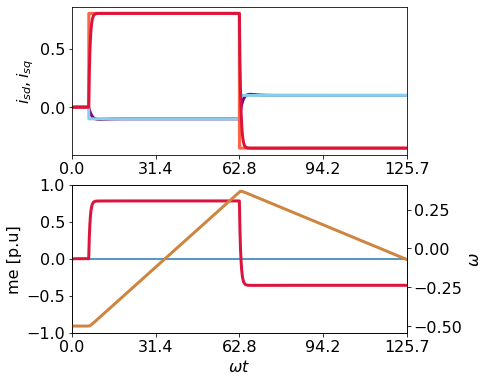

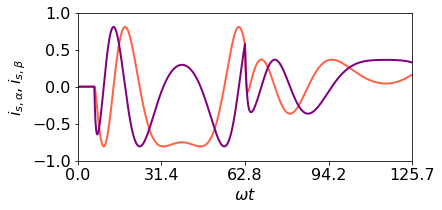

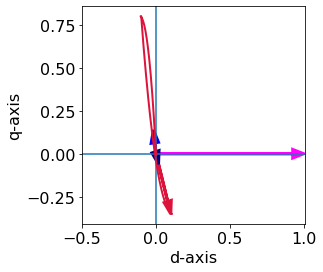

0.9


In [13]:
dirfig =  "C:/Users/ashwi/Documents/tex/lec/drives/figures/"
pl.figure(501, figsize = (6,6))
pl.rc('font', size = 16)
pl.subplot(2,1,1)
pl.plot(Tta,  isd, 'purple', Tta, isdref,'skyblue', lw=3) 
pl.plot(Tta, isqref,'tomato', Tta,isq ,'crimson' ,lw =3)
pl.xlim(0,tend)
pl.ylabel(r'$i_{sd}, i_{sq}$' )
pl.xticks(np.linspace(0,tend,5))
ax1 = pl.subplot(2,1,2)
ax1.axhline(0)
ax1.plot(Tta, me, 'crimson', lw =3)
ax1.set_yticks(np.linspace(-1.0,1.0,5))
ax1.set_ylabel('me [p.u]')
# ax1.plot(Tta,gamma, 'navy', Tta, FCangle)
ax2 = ax1.twinx()
ax2.set_ylabel('$\omega$')
ax2.plot(Tta,w, 'peru', lw =3)

# pl.ylabel(r'$\psi_{r,\alpha}, \psi_{r,\beta}$' )
ax1.set_xlabel(r'$\omega t$')
ax1.set_xlim(0,tend)
ax1.set_xticks(np.linspace(0,tend,5))
# pl.savefig(dirfig + "PMSMdqSpeedConurrentsvst.pdf", bbox_inches = 'tight', transparent = True)


pl.figure(521, figsize = (6,6))
pl.rc('font', size = 16)
# pl.subplot(2,1,1)
# pl.plot(Tta,  psiradash, 'r', Tta,psirbdash ,'purple' ,lw =2)
# pl.xlim(0,tend)
# # pl.ylabel(r'$\psi_{s\alpha}^{\prime}, \psi_{s\beta}^{\prime}$' )
# pl.xticks(np.linspace(0,tend,5))
# pl.yticks(np.linspace(-1.0,1.0,5))
pl.subplot(2,1,2)
pl.plot(Tta, isa, 'tomato', lw =2)
pl.plot(Tta,isb, 'purple', lw =2)
pl.ylabel(r'$i_{s,\alpha}, i_{s,\beta}$' )
pl.xlabel(r'$\omega t$')
pl.xlim(0,tend)
pl.xticks(np.linspace(0,tend,5))
pl.yticks(np.linspace(-1.0,1.0,5))
# pl.savefig(dirfig + "PMSMdqCurrentconsvst.pdf", bbox_inches = 'tight', transparent = True)

pl.figure(523, figsize = (4,4))
pl.rc('font', size = 16)
pl.axhline(0)
pl.axvline(0)
pl.plot(isd,isq,'crimson', lw =2, label = 'estimate')
# pl.plot(psird, psirq, 'blue', lw =2 , label = "actual")
pl.arrow(0,0,psird[-1],psirq[-1], fc = 'magenta', ec = 'magenta',  head_width = 0.05\
         ,length_includes_head = True, lw =3)
pl.arrow(0,0,isd[-1],isq[-1], fc = 'crimson', ec = 'crimson',  head_width = 0.05\
         ,length_includes_head = True, lw =3)
pl.arrow(0,0,usd[-1],usq[-1], fc = 'navy', ec = 'navy',  head_width = 0.05\
         ,length_includes_head = True, lw =3)
pl.arrow(0,0,usd[index1],usq[index1], fc = 'blue', ec = 'blue',  head_width = 0.05\
         ,length_includes_head = True, lw =3)

# pl.axis('equal')
pl.xlabel('d-axis')
pl.ylabel('q-axis')
pl.xlim(-0.5,1.01)
# pl.savefig(dirfig + "PMSMdqXYwCC.pdf", bbox_inches = 'tight', transparent = True)
pl.show()
print(psirm)

-0.31112224448897796 -0.8035426731078905 2.3004370830457788 1.43143429716576 0.6986


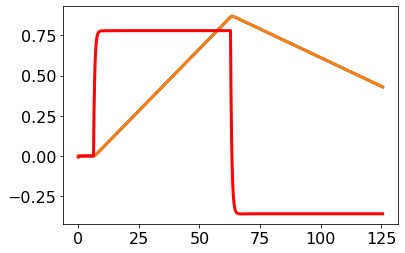

In [14]:
y0 = [0,0]
wxx = np.zeros(len(Tta))
for ii in range(len(Tta)):
    params = [me[ii],0.0,tmech]
    sol2a = odeint(rotor_dyndq, y0, [0,delta_t], args = (params,), atol = abserr, rtol= relerr)
    sol2[ii] = sol2a[-1]
    y0 = sol2a[-1]
    wxx[ii] = sol2[ii][0]
    
# wxx = sol2[:,0]    
pl.plot(Tta,sol2[:,0], Tta, wxx, lw =3)
pl.plot(Tta,me, 'r', lw =3)
# pl.plot(Tta,sol2[:,1], lw =3)

print(ws*lq/ld, ws*ld/lq, 1.0/lq, 1.0/ld, ld, )

### 4x4 PMSM model salient rotor


In [15]:
def PMSM_dynstepdq44(X,t,params):
    """Defines a function to calculate the derivatives for a 2x2 PMS motor dynamice
       1. Uses state variables stator current $\vec{i}_s$ id d-q coordinates.
       2. Is non-linear and uses the state variable $\omega$ rotor angular velocity to describe
          rotor dynamics. rotor angular velocity will be go from outside as parameter
       3. calls mach_im function to calculate the system equation coefficients
       4. mach_im will in  turn call mach_para function.
       5. uses normalized time 2*np.pi*50*t
       6. This is to be used in a for loop for the time span
    """
    x0 = X[0]  #isd
    x1 = X[1]  #isq
    x2 = X[2]  #ws
    x3 = X[3]  #rotor angle
#     wx = X[5]
    u1,u2,w,rs,ld,lq,tmech,psirm = params #needs state variable ws from outside
    #Convert voltage from stator coordinates into field coordinates
#     ud = u1*np.cos(x3) + u2*np.sin(x3)
#     uq = -u1*np.sin(x3) + u2*np.cos(x3)
    #
    ud = u1
    uq = u2
#     rs,ld,lq,tmech,psirm = mach_parapm(mach_ramu)
#     rs,ld,lq,tmech,psirm = mach_parapm(mach_servodq)
    mdiff = psirm*x1 + (ld - lq)*x0*x1 - mL
#     print(A[1][0],A[1][1],A[1][2],A[1][3],B[4][0])
    dx0dt = -(rs/ld)*x0 +w*(lq*x1)/ld + ud/ld
    dx1dt = - w*(ld*x0)/lq -(rs/lq)*x1 - w*psirm/lq + uq/lq
    dx2dt = mdiff/tmech
    dx3dt = x2
    return [dx0dt,dx1dt,dx2dt,dx3dt]

In [16]:
#Preparing simulation for current control
# We will use for loop


# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-3

tend = 20*2*np.pi
tstart = 0.0
delta_t = 0.005
n = 100000
n2 = int(100*2*np.pi/0.01)
ws = -0.5
mL = 0.0
Tta = np.arange(tstart, tend,delta_t)
# Tta = np.linspace(tstart, tend, n2)
#delta_t = Tta[1] - Tta[0]
usa = np.zeros(len(Tta))
usb = np.zeros(len(Tta))
sol1 = np.zeros((len(Tta),4))
sol2 = np.zeros((len(Tta),2))
FCangle = np.zeros(len(Tta))
gamma = np.zeros(len(Tta))
# Field coordinate currents
cosdelta = np.zeros(len(Tta))
sindelta = np.zeros(len(Tta))
isd = np.zeros(len(Tta))
isq = np.zeros(len(Tta))
isa = np.zeros(len(Tta))
isb = np.zeros(len(Tta))
usd = np.zeros(len(Tta))
usq = np.zeros(len(Tta))
eid = np.zeros(len(Tta))
eiq = np.zeros(len(Tta))
w = np.zeros(len(Tta))
w2 = np.zeros(len(Tta))
gamma2 = np.zeros(len(Tta))


rs,ld,lq,tmech,psirm = mach_parapm(mach_ramu)
# rs,ld,lq,tmech,psirm = mach_parapm(mach_servodq)

#Creating reference values for isd and isq
isdrefval = -0.1
isdref = np.zeros(len(Tta))
isqref = np.zeros(len(Tta))

isqref1 = 0.0
isqref2 = 0.8
isqref3 = -0.35
for ii in range(len(Tta)):
    isdref[ii] = 0.0
    if (Tta[ii]>=10*2*np.pi):
        isqref[ii] = isqref3
        isdref[ii] = -isdrefval
    elif(Tta[ii]>=1*2*np.pi):
        isqref[ii]=isqref2
        isdref[ii] = isdrefval
    else:
        isqref[ii]=isqref1
    

psird = np.zeros(len(Tta))
psirq = np.zeros(len(Tta))

me = np.zeros(len(Tta))
x0 = [0.0,0.0,ws,0]

kpd = ld*1
Tid = 25.0e1

kpq = lq*2
Tiq = 25.0e1

Kparamsd = [kpd,Tid]
Kparamsq = [kpq,Tiq]

#isdref = 0.26
#isqref = 0.75
#The intial value error will never get corrected in 
#rotor angle
y0 = [ws,0]

for ii in range(len(Tta)):
    #Start controller after first step
    if ii>=0:
        eid[ii] = isdref[ii-1] - isd[ii-1]
        PIed = [eid[ii],eid[ii-1]]
        usd[ii] = PIcon(PIed, usd[ii-1], delta_t,Kparamsd) 
        eiq[ii] = isqref[ii-1] - isq[ii-1]
        PIeq = [eiq[ii],eiq[ii-1]]
        usq[ii] = PIcon(PIeq, usq[ii-1], delta_t,Kparamsq)
#         usd[ii] = 0
#         usq[ii] =.0001
#     if ws>=1.0:
#         a = 1.0
#     else: 
#         a = ws
#     usa[ii] = a*np.cos(ws*Tta[ii])
#     usb[ii] = a*np.sin(ws*Tta[ii])
#     usa[ii] = usd[ii-1]*cosdelta[ii-1] - usq[ii-1]*sindelta[ii-1]
#     usb[ii] = usq[ii-1]*cosdelta[ii-1] + usd[ii-1]*sindelta[ii-1]

    params = [usd[ii], usq[ii],w[ii],rs,ld,lq,tmech,psirm]
    sol1a = odeint(PMSM_dynstepdq44,x0,[0,delta_t], args = (params,),atol = abserr, rtol= relerr)
    sol1[ii]= sol1a[-1]
#     display(sol1a[-1])
    x0 = sol1a[-1]
    me[ii] = 1.0*sol1[ii][1] + (ld -lq)*sol1[ii][0]*sol1[ii][1]
    paramsw = [me[ii],0.0,tmech]
    sol2a = odeint(rotor_dyndq, y0, [0,delta_t], args = (paramsw,), atol = abserr, rtol= relerr)
    y0 = sol2a[-1]
    sol2[ii] = sol2a[-1]
    #Rotor angle using internal angle
    FCangle[ii] = sol1[ii][3]
    gamma[ii] = sol1[ii][3]
    w[ii] = sol1[ii][2]
    #using resolver output
#     FCangle[ii] = sol2[ii]
    cosdelta[ii] = np.cos(FCangle[ii])
    sindelta[ii] = np.sin(FCangle[ii])
    isd[ii] = sol1[ii][0]
    isq[ii] = sol1[ii][1]
    w2[ii] = sol2[ii][0]
    gamma2[ii] = sol2[ii][1]
    #Coordinate transformation 
    #Convert stator coordinate current to field coordinates
    isa[ii] = sol1[ii][0]*cosdelta[ii] - sol1[ii][1]*sindelta[ii]
    isb[ii] = sol1[ii][1]*cosdelta[ii] + sol1[ii][0]*sindelta[ii]
    #Rotor flux in field coordinates Using estimator output as in practice
    #actual flux will not be available for measurement
    psird[ii] = 1.0
    psirq[ii]= 0.0

    
# isd = sol1[:, 0]
# isq = sol1[:, 1]
# w2 = sol2[:, 0]
# gamma2 = sol2[:,1]



# rs,ld,lq,tmech,psirm = mach_parapm(mach_servodq)

# me = 1.0*isq + (ld - lq)*isd*isq


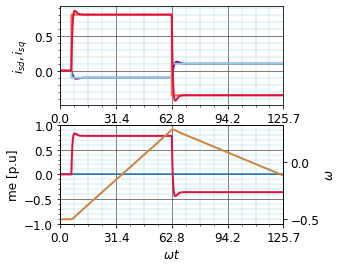

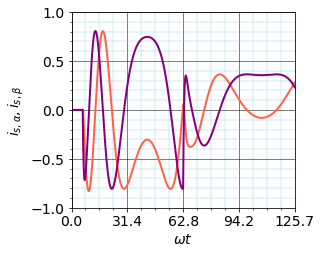

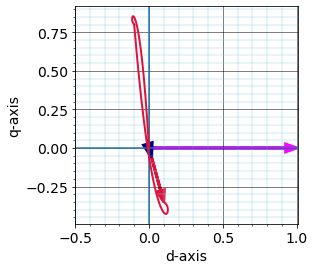

0.9


In [17]:
dirfig =  "C:/Users/ashwi/Documents/tex/lec/drives/figures/"
pl.figure(501, figsize = (4,4))
pl.rc('font', size = 12)
pl.subplot(2,1,1)
pl.plot(Tta,  isd, 'purple', Tta, isdref,'skyblue', lw=2) 
pl.plot(Tta, isqref,'tomato', Tta,isq ,'crimson' ,lw =2)
pl.xlim(0,tend)
pl.ylabel(r'$i_{sd}, i_{sq}$' )
pl.xticks(np.linspace(0,tend,5))
pl.minorticks_on()
pl.grid(which = 'major', lw =0.5, c = 'k')
pl.grid(which = 'minor', lw =0.4, color = 'skyblue')

ax1 = pl.subplot(2,1,2)
ax1.axhline(0)
ax1.plot(Tta, me, 'crimson', lw =2)
ax1.set_yticks(np.linspace(-1.0,1.0,5))
ax1.set_ylabel('me [p.u]')
# ax1.plot(Tta,gamma, 'navy', Tta, FCangle)
ax2 = ax1.twinx()
ax2.set_ylabel('$\omega$')
ax2.plot(Tta,w, 'peru', lw =2)
# ax2.plot(Tta,w2,'brown',lw =2)

# pl.ylabel(r'$\psi_{r,\alpha}, \psi_{r,\beta}$' )
ax1.set_xlabel(r'$\omega t$')
ax1.set_xlim(0,tend)
ax1.set_xticks(np.linspace(0,tend,5))
ax1.minorticks_on()
ax1.grid(which = 'major', lw =0.5, c = 'k')
ax1.grid(which = 'minor', lw =0.4, color = 'skyblue')
# pl.savefig(dirfig + "PMSMdqSpeedConurrentsvst.pdf", bbox_inches = 'tight', transparent = True)


pl.figure(521, figsize = (4,3.6))
pl.rc('font', size = 14)
# pl.subplot(2,1,1)
# pl.plot(Tta,  psiradash, 'r', Tta,psirbdash ,'purple' ,lw =2)
# pl.xlim(0,tend)
# # pl.ylabel(r'$\psi_{s\alpha}^{\prime}, \psi_{s\beta}^{\prime}$' )
# pl.xticks(np.linspace(0,tend,5))
# pl.yticks(np.linspace(-1.0,1.0,5))
pl.subplot(1,1,1)
pl.plot(Tta, isa, 'tomato', lw =2)
pl.plot(Tta,isb, 'purple', lw =2)
pl.ylabel(r'$i_{s,\alpha}, i_{s,\beta}$' )
pl.xlabel(r'$\omega t$')
pl.xlim(0,tend)
pl.xticks(np.linspace(0,tend,5))
pl.yticks(np.linspace(-1.0,1.0,5))
pl.minorticks_on()
pl.grid(which = 'major', lw =0.5, c = 'k')
pl.grid(which = 'minor', lw =0.4, color = 'skyblue')
# pl.savefig(dirfig + "PMSMdqCurrentconsvst.pdf", bbox_inches = 'tight', transparent = True)

pl.figure(523, figsize = (4,4))
pl.rc('font', size = 14)
pl.axhline(0)
pl.axvline(0)
pl.plot(isd,isq,'crimson', lw =2, label = 'estimate')
# pl.plot(psird, psirq, 'blue', lw =2 , label = "actual")
pl.arrow(0,0,psird[-1],psirq[-1], fc = 'magenta', ec = 'magenta',  head_width = 0.05\
         ,length_includes_head = True, lw =3)
pl.arrow(0,0,isd[-1],isq[-1], fc = 'crimson', ec = 'crimson',  head_width = 0.05\
         ,length_includes_head = True, lw =3)
pl.arrow(0,0,usd[-2],usq[-2], fc = 'navy', ec = 'navy',  head_width = 0.06\
         ,length_includes_head = True, lw =3)
# pl.arrow(0,0,usd[index1],usq[index1], fc = 'blue', ec = 'blue',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)

# pl.axis('equal')
pl.xlabel('d-axis')
pl.ylabel('q-axis')
pl.xlim(-0.5,1.01)
# pl.savefig(dirfig + "PMSMdqXYwCC.pdf", bbox_inches = 'tight', transparent = True)
pl.minorticks_on()
pl.grid(which = 'major', lw =0.5, c = 'k')
pl.grid(which = 'minor', lw =0.4, color = 'skyblue')
pl.show()
print(psirm)